# 🏠 Notebook Overview

This notebook presents a comprehensive workflow for data preprocessing, feature engineering, and exploratory analysis for a house price prediction task using the Ames Housing dataset. The main sections and their purposes are outlined below:

---

## 1. 📥 Data Loading and Initial Exploration

- **Load and Preview Data:** Training and test datasets are loaded from CSV files. Initial data shapes and previews are displayed to understand the structure and basic statistics.
- **Feature Identification:** Numerical and categorical features are identified, and irrelevant columns (like 'Id' and 'SalePrice') are excluded from modeling features.

---

## 2. 🚨 Outlier Detection and Removal

- **Distribution Analysis:** Kernel density plots are used to visualize feature distributions and identify outliers in columns such as `LotFrontage`, `LotArea`, and `MasVnrArea`.
- **Outlier Removal:** Records with extreme values not present in the test set are removed from the training data to improve model generalizability.

---

## 3. 🔗 Data Combination for Preprocessing

- **Dataset Concatenation:** Training and test datasets are combined to ensure consistent preprocessing and feature engineering across both sets.

---

## 4. 🧩 Missing Value Imputation

- **Missing Value Summary:** Columns with missing values are identified, and the extent of missingness is summarized for train, test, and combined datasets.
- **Imputation Strategies:** 
    - Contextual imputation (e.g., median `LotFrontage` by `Neighborhood`)
    - Filling categorical features with 'NA' or most frequent values
    - Filling numerical features with 0 where absence is implied
    - Special handling for high-missing-rate columns (e.g., `PoolQC`, `MiscFeature`, `Fence`)

---

## 5. 🛠️ Feature Engineering

- **Time-Based Features:** New features are created to capture the age of the house, garage, and remodel events, including binary indicators for recent remodels.
- **Seasonality Features:** Sale month is encoded as a categorical variable, and monthly average sale prices and counts are mapped to each record.
- **Dwelling Type Encoding:** `MSSubClass` is treated as a categorical variable, with additional features for newer dwellings and average prices by subclass.
- **Ordinal Encoding:** Quality and condition features are mapped to ordinal scales for improved model interpretability.
- **Location Features:** Neighborhoods are mapped to latitude/longitude, and Euclidean distance to city center is calculated. Neighborhoods are also binned by median price.

---

## 6. 📦 Final Data Preparation

- **Feature Selection:** Top features are selected for modeling based on domain knowledge and exploratory analysis.
- **Train/Test Split:** The processed data is split back into training and test sets, ready for modeling.

---

## 🏁 Summary

This notebook provides a robust pipeline for preparing the Ames Housing dataset for predictive modeling. It covers data cleaning, outlier handling, missing value imputation, feature engineering, and exploratory analysis, with clear documentation and visual support for each step. The resulting processed data is well-structured for downstream machine learning tasks.

In [1]:
# pandas
import pandas as pd

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

from IPython.display import display

# remove warnings
import warnings
warnings.filterwarnings('ignore')

## 1. 📥 Data Loading and Initial Exploration

This section is essential for understanding the structure, content, and basic statistics of the dataset before any preprocessing or modeling.

- 📊 **Load and Preview Data:**  
    Gain an overview of the training and test datasets, including their shapes and sample records.

- 🔍 **Feature Identification:**  
    Identify numerical and categorical features, and exclude irrelevant columns (such as `Id` and `SalePrice`) from modeling.

- ⚠️ **Spot Issues:**  
    Detect potential problems like missing values or outliers early in the workflow.

- 🧭 **Foundation for Workflow:**  
    Initial exploration ensures that all subsequent data cleaning and feature engineering steps are based on a clear understanding of the raw data.

In [ ]:
# Load training and test datasets from CSV files
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Print the shape (number of rows and columns) of the training data
print(train_data.shape)
# Display the first row of the training data for a quick preview
display(train_data.head(1))
# Uncomment the next line to display detailed info about training data columns and types
# display(train_data.info())

# Print the shape of the test data
print(test_data.shape)
# Display the first row of the test data for a quick preview
display(test_data.head(1))
# Uncomment the next line to display detailed info about test data columns and types
# display(test_data.info())

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


In [ ]:
# Get all numerical columns from train_data except those of type 'object'
previous_num_columns = train_data.select_dtypes(exclude=['object']).columns.values.tolist()

# Remove 'Id' and 'SalePrice' since they are not features for modeling
previous_num_columns.remove('Id')
previous_num_columns.remove('SalePrice')

# Print the list of numerical feature columns
print(previous_num_columns)

# Explanation:
# - select_dtypes(exclude=['object']) selects columns with numeric types (int, float, etc.)
# - We exclude 'Id' (identifier) and 'SalePrice' (target variable) from the feature list.
# - The result is a list of numerical features available for analysis or modeling.

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


## 2. 🚨 Outlier Detection and Removal

- **Why Outlier Detection Matters:**  
    🚨 Outlier detection and removal is essential for building robust predictive models. Outliers can distort statistical analyses, bias model training, and reduce generalizability to unseen data.

- **Approach:**  
    🔍 By identifying and removing extreme values that do not exist in the test set, we ensure the model learns patterns representative of the real-world data distribution.

- **Benefits:**  
    ✅ Improves accuracy and reliability of predictions  
    ✅ Prevents overfitting  
    ✅ Enhances interpretability of downstream analyses

train: (0,)
test: (0,)


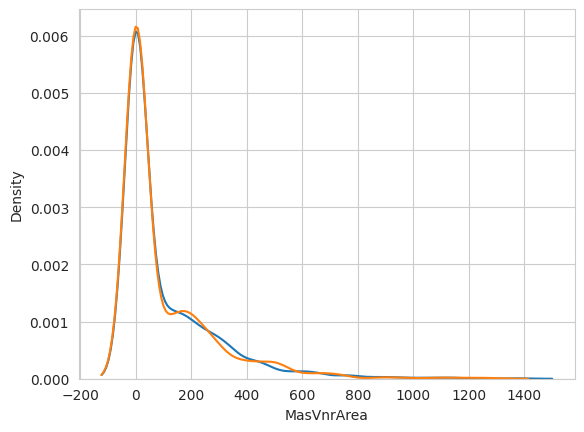

In [93]:
# Set the column to analyze
test_column = 'MasVnrArea'

# Plot the kernel density estimate (KDE) for the MasVnrArea column in the training data
sns.kdeplot(train_data[test_column])
# Plot the KDE for the MasVnrArea column in the test data
sns.kdeplot(test_data[test_column])

# Print the number of records in the training set where MasVnrArea > 1500 (potential outliers)
print('train:', train_data[test_column][train_data[test_column] > 1500].shape)
# Print the number of records in the test set where MasVnrArea > 1500 (potential outliers)
print('test:', test_data[test_column][test_data[test_column] > 1500].shape)

# Explanation:
# - This code visualizes the distribution of the MasVnrArea feature for both train and test datasets.
# - It helps to identify outliers and compare distributions between train and test sets.
# - The print statements show how many records have unusually large values (>1500), which can be useful for outlier detection and data cleaning.



There are some records in the training set with values outside a certain range, which do not exist in the test set. These outliers are removed from the training set.

- LotFrontage: 2 records > 200 in train, none in test
- LotArea   : 5 records > 70000 in train, none in test
- MasVnrArea: 1 record > 1500 in train, none in test

In [94]:
# Print the shape of the training data before removing outliers
print(train_data.shape)

# Remove records from train_data where LotFrontage > 200 (outliers not present in test set)
train_data.drop(train_data[train_data["LotFrontage"] > 200].index, inplace=True)

# Remove records from train_data where LotArea > 70000 (outliers not present in test set)
train_data.drop(train_data[train_data["LotArea"] > 70000].index, inplace=True)

# Remove records from train_data where MasVnrArea > 1500 (outliers not present in test set)
train_data.drop(train_data[train_data["MasVnrArea"] > 1500].index, inplace=True)

# Print the shape of the training data after removing outliers
print(train_data.shape)

# Store the updated number of records in train_data after outlier removal
train_length = train_data.shape[0]

# Explanation:
# - Outliers in LotFrontage, LotArea, and MasVnrArea are removed from the training set because such extreme values do not exist in the test set.
# - This helps prevent the model from learning patterns that are not generalizable to the test data.
# - The shape print statements show how many records were removed.
# - train_length is updated to reflect the new size of the training set.

(1452, 81)
(1452, 81)


## 3. 🔗 Data Combination for Preprocessing

- 🔄 **Why Combine Datasets?**  
    Combining training and test datasets before preprocessing ensures that all transformations—such as missing value imputation, encoding, and feature engineering—are applied consistently. This unified approach prevents discrepancies and data leakage, maintaining data integrity.

- 🧩 **Benefits:**  
    - Consistent feature transformations  
    - Improved model generalizability  
    - Avoids data leakage between train and test sets  
    - Simplifies workflow for downstream modeling

- 🚀 **Summary:**  
    By processing train and test data together, we ensure that the model is trained and evaluated on data that has undergone identical preprocessing steps.

In [ ]:
# Combine train and test datasets for feature engineering and preprocessing.
# - The first line concatenates the training data (up to and including 'SalePrice') and the test data.
# - This is useful for applying transformations (like encoding or imputing missing values) consistently across both datasets.
conbined_data = pd.concat([train_data.loc[:, : 'SalePrice'], test_data])

# Align columns to match the test_data structure.
# - This ensures that conbined_data has the same columns as test_data, which is important for making predictions later.
conbined_data = conbined_data[test_data.columns]

# Display the first row of the combined dataset for a quick preview.
display(conbined_data.head(1))

# Print the shape (number of rows and columns) of the combined dataset.
print(conbined_data.shape)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal


(2911, 80)


## 4. 🧩 Missing Value Imputation

Missing value imputation is a crucial step in any data preprocessing workflow.  
- 🛡️ **Ensures Data Integrity:** Handling missing values prevents errors and inconsistencies during analysis and modeling.
- 📈 **Improves Model Performance:** Proper imputation strategies help models learn from complete data, reducing bias and variance.
- 🧠 **Preserves Information:** Thoughtful imputation (using domain knowledge or feature relationships) retains as much useful information as possible.
- 🚀 **Enables Feature Engineering:** Clean, imputed data allows for robust feature creation and transformation in later steps.

By addressing missing values systematically, we build a solid foundation for accurate and reliable predictive modeling.

In [ ]:
# Get columns with missing data in the combined dataset
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()

# Count missing values for each column in train, test, and combined datasets
train_null = train_data[has_null_columns].isnull().sum()
test_null = test_data[has_null_columns].isnull().sum()
conbined_null = conbined_data[has_null_columns].isnull().sum()

print('how many data missed each column of train/test/conbine datas')

# Create a DataFrame to summarize missing values for each column across datasets
missed_data = pd.DataFrame(
    data=[train_null, test_null, conbined_null],
    index=['train', 'test', 'conbine'],
    columns=has_null_columns
)

# Display the summary DataFrame
missed_data

# Explanation:
# - has_null_columns: List of columns in conbined_data that have missing values.
# - train_null, test_null, conbined_null: Series showing the count of missing values for each column in train, test, and combined datasets.
# - missed_data: DataFrame that organizes the missing value counts for easy comparison.
# - This helps to quickly identify which columns have missing data and how much is missing in each dataset.

how many data missed each column of train/test/conbine datas


,MSZoning,LotFrontage,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
train,0,256,1362,0,0,0,868,8,37,37,...,81,81,0,0,81,81,1446,1171,1400,0
test,4,227,1352,2,1,1,894,15,44,45,...,78,78,1,1,78,78,1456,1169,1408,1
conbine,4,483,2714,2,1,1,1762,23,81,82,...,159,159,1,1,159,159,2902,2340,2808,1


In [ ]:
def fill_missing_conbined_data(column, value):
    # Fill missing values in the specified column of conbined_data with the provided value.
    # This function locates all rows in conbined_data where the given column is null (missing),
    # and sets those entries to the specified value.
    # Useful for handling missing data during preprocessing and feature engineering.
    conbined_data.loc[conbined_data[column].isnull(),column] = value

**LotFrontage/LotArea**

For missing LotFrontage (Linear feet of street connected to property), the average value is usually used for imputation, but it may be related to different Neighborhoods.

<Axes: xlabel='Neighborhood'>

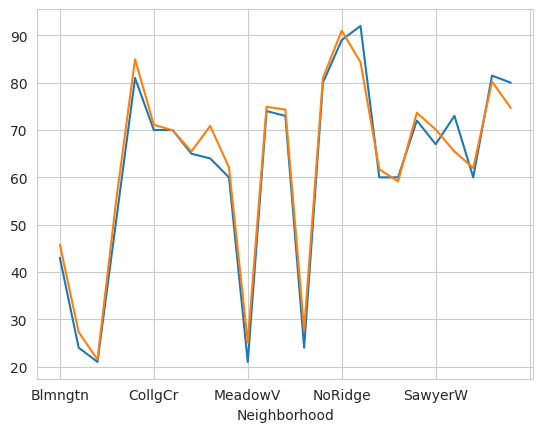

In [95]:
# Plot the median LotFrontage for each Neighborhood.
# This helps visualize how the typical street frontage varies by neighborhood,
# which can reveal location-based patterns or differences in lot sizes.
conbined_data['LotFrontage'].groupby(conbined_data["Neighborhood"]).median().plot()

# Plot the mean LotFrontage for each Neighborhood.
# Comparing the mean and median can highlight the effect of outliers or skewed distributions
# in LotFrontage within each neighborhood.
conbined_data['LotFrontage'].groupby(conbined_data["Neighborhood"]).mean().plot()

In [96]:
# Calculate the median LotFrontage for each Neighborhood.
# This mapping will be used to impute missing LotFrontage values based on the neighborhood.
lf_neighbor_map = conbined_data['LotFrontage'].groupby(conbined_data["Neighborhood"]).median()
    
# Find rows in conbined_data where LotFrontage is missing (NaN).
rows = conbined_data['LotFrontage'].isnull()

# For each row with missing LotFrontage, fill it with the median LotFrontage of its Neighborhood.
# This leverages local neighborhood information for more accurate imputation than using a global mean/median.
conbined_data['LotFrontage'][rows] = conbined_data['Neighborhood'][rows].map(lambda neighbor : lf_neighbor_map[neighbor])

In [97]:
# Display rows in conbined_data where 'LotFrontage' is missing (NaN).
# This is useful for inspecting which records still have missing values after imputation,
# and for verifying that the imputation process worked as expected.
# It can also help identify any patterns or issues with the remaining missing data.
conbined_data[conbined_data['LotFrontage'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageGrade,ExterGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,TotalBath,TotalPorchSF,AllSF,BoughtOffPlan


**Alley**

In [99]:
# Display the shape (number of rows and columns) of the combined dataset,
# and the shape of the subset where 'Alley' is missing (NaN).
# This helps to quickly check how many records are in the combined data,
# and how many records still have missing values for the 'Alley' column.
conbined_data.shape, conbined_data[conbined_data['Alley'].isnull()].shape

((2911, 149), (0, 149))

Missing data: 2,721 out of 2,919 records are missing (93.2%). Since the missing rate is too high, fill the missing values with "NA" (NA = No alley access).

In [100]:
# Fill missing values in the 'Alley' column of conbined_data with 'NA'.
# Explanation:
# - The 'Alley' column has a very high rate of missing values (over 93%).
# - 'NA' is used to indicate 'No alley access', which is a reasonable assumption given the data.
# - This approach prevents issues with downstream analysis or modeling due to missing values.
fill_missing_conbined_data('Alley', 'NA')

**MasVnrType / MasVnrArea**

Fill missing values in MasVnrType with the most frequent type, and missing values in MasVnrArea with 0.

In [102]:
# Fill missing values in 'MasVnrType' with 'None'.
# Explanation:
# - 'MasVnrType' (Masonry veneer type) has many missing values in both train and test sets.
# - The most frequent value is 'None', which means no masonry veneer.
# - Filling with 'None' is a common approach for categorical features with missing values that indicate absence.
conbined_data['MasVnrType'].fillna('None', inplace=True)

# Fill missing values in 'MasVnrArea' with 0.
# Explanation:
# - 'MasVnrArea' (Masonry veneer area) is a numerical feature.
# - Missing values likely correspond to houses with no masonry veneer, so 0 is appropriate.
# - This ensures the column is fully numeric and avoids issues with downstream modeling.
conbined_data['MasVnrArea'].fillna(0, inplace=True)

**BsmtQual / BsmtCond / BsmtExposure / BsmtFinType1 / BsmtFinType2**
- BsmtQual: 37 / 44 / 81
- BsmtCond: 37 / 45 / 82
- BsmtExposure: 38 / 44 / 82
- BsmtFinType1: 37 / 42 / 79
- BsmtFinType2: 38 / 42 / 80

In [104]:
# List of basement-related columns for missing value handling and feature engineering.
# Explanation:
# - These columns include both categorical (quality/type) and numerical (finished area) attributes of the basement.
# - 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2' are categorical features describing the basement's quality, condition, exposure, and finish type.
# - 'BsmtFinSF1', 'BsmtFinSF2' are numerical features representing the square footage of finished basement areas.
# - This list is used to systematically process missing values and transformations for all basement-related features.
basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']

In [106]:
# Fill missing string-type basement columns with 'NA', meaning No Basement
# Explanation:
# - Iterate over each column in basement_cols.
# - For columns that do not contain 'FinSF' in their name (i.e., categorical basement columns),
#   fill missing values with 'NA' to indicate 'No Basement'.
# - This is a common approach for categorical features where missing values represent absence.
for column in basement_cols:
    if 'FinSF'not in column:
        # NA	No Basement
        fill_missing_conbined_data(column, 'NA')

In [108]:
# For numerical BsmtFinSF1 and BsmtFinSF2 columns, fill missing values with 0
# Explanation:
# - 'BsmtFinSF1' and 'BsmtFinSF2' represent the square footage of finished basement areas.
# - Missing values in these columns likely indicate no finished basement area, so filling with 0 is appropriate.
# - This ensures the columns remain numeric and avoids issues with downstream analysis or modeling.
fill_missing_conbined_data('BsmtFinSF1', 0)
fill_missing_conbined_data('BsmtFinSF2', 0)

**Electrical**

Missing one value, fill with the most frequent value.

<Axes: xlabel='count', ylabel='Electrical'>

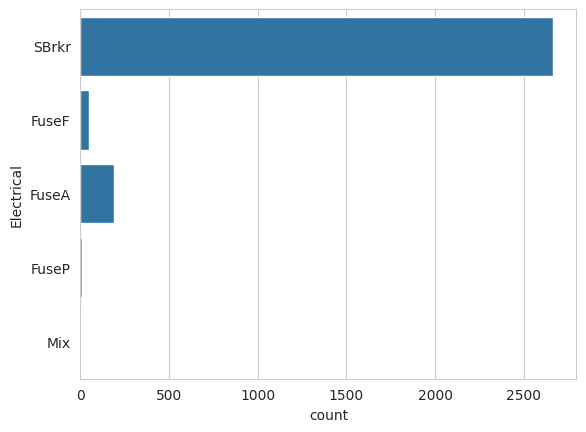

In [110]:
# Visualize the distribution of the 'Electrical' feature in the combined dataset using a count plot.
# Explanation:
# - sns.countplot() creates a bar plot showing the frequency of each category in the 'Electrical' column.
# - This helps to quickly identify the most common electrical systems and spot any rare or missing categories.
# - Useful for understanding categorical feature distributions and guiding missing value imputation or encoding.
sns.countplot(conbined_data['Electrical'])

In [111]:
# Fill missing values in the 'Electrical' column of conbined_data with 'SBrkr'.
# Explanation:
# - The 'Electrical' column has only one missing value in the training set and none in the test set.
# - 'SBrkr' (Standard Circuit Breakers) is the most frequent value in both train and test datasets.
# - Filling with the most common value is a standard approach for categorical features with very few missing values.
# - This ensures consistency and avoids introducing bias from rare categories.
fill_missing_conbined_data('Electrical', 'SBrkr')

**FireplaceQu**

For records where Fireplaces is 0, set FireplaceQu to NA, meaning No Fireplace. This accounts for the 1,420 missing values.

In [112]:
# For records where Fireplaces is 0, set FireplaceQu to NA, meaning No Fireplace. This accounts for the 1,420 missing values.
# Explanation:
# - The 'FireplaceQu' column describes the quality of the fireplace.
# - Many records have missing values in 'FireplaceQu', which usually means there is no fireplace in the house.
# - By filling missing 'FireplaceQu' values with 'NA', we explicitly indicate "No Fireplace" for these records.
# - This helps downstream feature engineering and modeling by making the absence of a fireplace explicit, rather than leaving it as a missing value.
fill_missing_conbined_data('FireplaceQu', 'NA')

**PoolQC**

PoolQC has 2,909 missing values. Is it related to PoolArea?

In [114]:
# Fill missing values in the 'PoolQC' column of conbined_data with 'NA'.
# Explanation:
# - 'PoolQC' (Pool Quality) has a very high rate of missing values (almost all records).
# - Most houses do not have a pool, so missing values likely indicate "No Pool".
# - Filling with 'NA' makes this explicit and avoids issues with downstream analysis or modeling.
# - This approach is consistent with how other categorical features with high missing rates are handled.
fill_missing_conbined_data('PoolQC', 'NA')

**MiscFeature**

In [115]:
# Fill missing values in the 'MiscFeature' column of conbined_data with 'NA'.
# Explanation:
# - 'MiscFeature' describes miscellaneous features not covered by other columns (e.g., shed, tennis court).
# - The vast majority of records have missing values in this column, which likely means "No miscellaneous feature".
# - Filling with 'NA' makes the absence explicit and avoids issues with downstream analysis or modeling.
# - This approach is consistent with how other categorical features with high missing rates are handled.
fill_missing_conbined_data('MiscFeature', 'NA')

**Fence**

In [116]:
# Fill missing values in the 'Fence' column of conbined_data with 'NA'.
# Explanation:
# - The 'Fence' column has a high rate of missing values in both train and test sets (over 80%).
# - 'NA' is used to indicate 'No fence', which is a reasonable assumption given the data.
# - This approach makes the absence of a fence explicit and avoids issues with downstream analysis or modeling.
fill_missing_conbined_data('Fence', 'NA')

**Garages**

In [118]:
# List of garage-related columns to inspect for missing values and feature engineering.
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']

# Display the first row in conbined_data where 'GarageType' is missing (NaN).
# Explanation:
# - This helps to inspect the pattern of missing values across all garage-related columns for a record with no garage type.
# - Useful for understanding how missingness in 'GarageType' relates to other garage features (e.g., is the whole garage info missing?).
# - Can guide imputation strategies (e.g., fill all garage columns with 'NA' or 0 if 'GarageType' is missing).
conbined_data[garage_cols][conbined_data['GarageType'].isnull()==True].head(1)

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageCars,GarageArea


In [120]:
# Fill missing string-type garage columns with 'NA', meaning No Garage
# Explanation:
# - Iterate over each column in garage_cols.
# - For columns that are not 'GarageCars' or 'GarageArea' (i.e., string/categorical garage columns),
#   fill missing values with 'NA' to indicate "No Garage".
# - For 'GarageCars' and 'GarageArea' (numerical columns), fill missing values with 0,
#   since missing likely means no garage (so no cars and no area).
# - This approach ensures that all garage-related columns have no missing values,
#   and the absence of a garage is encoded consistently for both categorical and numerical features.
for column in garage_cols:
    if column != 'GarageCars' and column != 'GarageArea':
        # NA	No Basement
        fill_missing_conbined_data(column, 'NA')
    else:
        fill_missing_conbined_data(column, 0)

**MSZoning**

<Axes: xlabel='count', ylabel='MSZoning'>

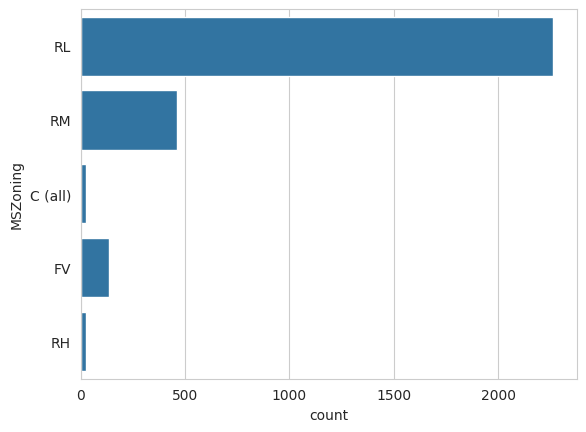

In [121]:
# Visualize the distribution of the 'MSZoning' feature in the combined dataset using a count plot.
# Explanation:
# - sns.countplot() creates a bar plot showing the frequency of each category in the 'MSZoning' column.
# - This helps to quickly identify the most common zoning classifications and spot any rare or missing categories.
# - Useful for understanding categorical feature distributions and guiding missing value imputation or encoding.
sns.countplot(conbined_data['MSZoning'])

In [122]:
# Fill missing values in the 'MSZoning' column of conbined_data with 'RL'.
# Explanation:
# - 'MSZoning' (zoning classification) has a few missing values in both train and test sets.
# - 'RL' (Residential Low Density) is the most common value in the dataset.
# - Filling missing values with the most frequent category is a standard approach for categorical features with low missing rates.
# - This ensures consistency and avoids introducing bias from rare categories.
fill_missing_conbined_data('MSZoning', 'RL')

**Utilities**

**Definitely ignoring Utilities** : all records are "AllPub", except for one "NoSeWa" in the train set and 2 NA in the test set.

<Axes: xlabel='count', ylabel='Utilities'>

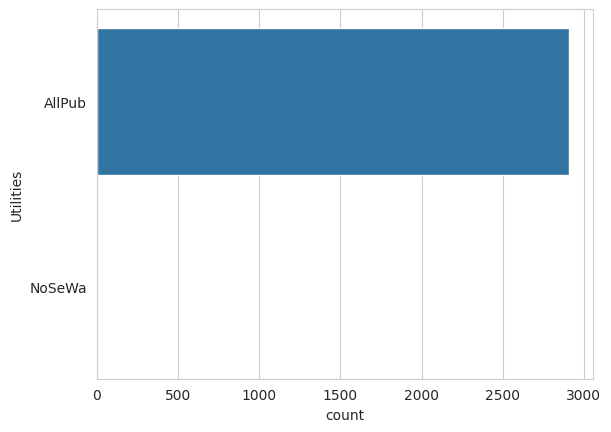

In [123]:
# Visualize the distribution of the 'Utilities' feature in the combined dataset using a count plot.
# Explanation:
# - sns.countplot() creates a bar plot showing the frequency of each category in the 'Utilities' column.
# - This helps to quickly identify the most common utility types and spot any rare or missing categories.
# - Useful for understanding categorical feature distributions and guiding missing value imputation or encoding.
sns.countplot(conbined_data['Utilities'])

In [124]:
# Fill missing values in the 'Utilities' column of conbined_data with 'AllPub'.
# Explanation:
# - The 'Utilities' column has a very low rate of missing values (only 2 in the test set and 0 in the train set).
# - 'AllPub' (All public utilities available) is the overwhelmingly dominant value in the dataset.
# - Filling missing values with 'AllPub' ensures consistency and avoids introducing bias from rare categories.
# - This approach is standard for categorical features with very few missing values and a clear majority value.
fill_missing_conbined_data('Utilities', 'AllPub')

**Exterior1st / Exterior2nd**

<Axes: xlabel='count', ylabel='Exterior1st'>

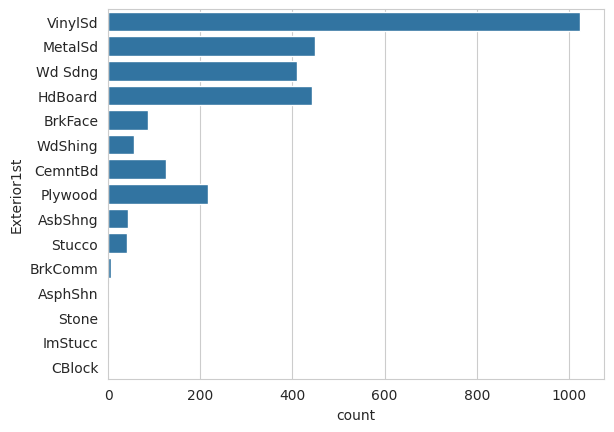

In [125]:
# Visualize the distribution of the 'Exterior1st' feature in the combined dataset using a count plot.
# Explanation:
# - sns.countplot() creates a bar plot showing the frequency of each category in the 'Exterior1st' column.
# - This helps to quickly identify the most common exterior materials and spot any rare or missing categories.
# - Useful for understanding categorical feature distributions and guiding missing value imputation or encoding.
sns.countplot(conbined_data['Exterior1st'])

In [126]:
# Fill missing values in the 'Exterior1st' column of conbined_data with 'VinylSd'.
# Explanation:
# - 'Exterior1st' represents the exterior covering on the house.
# - There is 1 missing value in the test set and none in the train set for this column.
# - 'VinylSd' (Vinyl Siding) is the most common value in both train and test datasets.
# - Filling missing values with the most frequent category is a standard approach for categorical features with low missing rates.
# - This ensures consistency and avoids introducing bias from rare categories.
fill_missing_conbined_data('Exterior1st', 'VinylSd')

<Axes: xlabel='count', ylabel='Exterior2nd'>

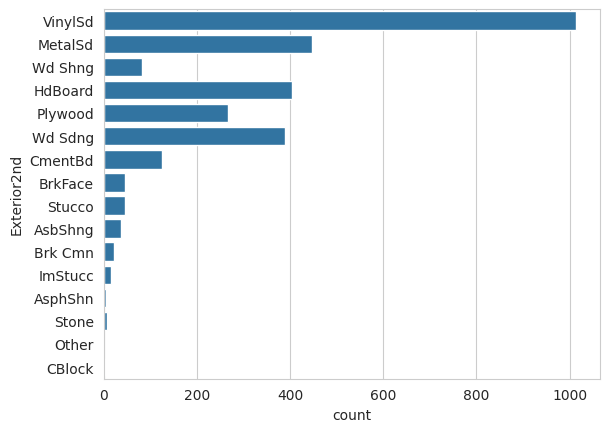

In [127]:
# Visualize the distribution of the 'Exterior2nd' feature in the combined dataset using a count plot.
# Explanation:
# - sns.countplot() creates a bar plot showing the frequency of each category in the 'Exterior2nd' column.
# - This helps to quickly identify the most common exterior materials and spot any rare or missing categories.
# - Useful for understanding categorical feature distributions and guiding missing value imputation or encoding.
sns.countplot(conbined_data['Exterior2nd'])

In [128]:
# Fill missing values in the 'Exterior2nd' column of conbined_data with 'VinylSd'.
# Explanation:
# - 'Exterior2nd' represents the secondary exterior covering on the house.
# - There is 1 missing value in the test set and none in the train set for this column.
# - 'VinylSd' (Vinyl Siding) is the most common value in both train and test datasets.
# - Filling missing values with the most frequent category is a standard approach for categorical features with low missing rates.
# - This ensures consistency and avoids introducing bias from rare categories.
fill_missing_conbined_data('Exterior2nd', 'VinylSd')

**BsmtUnfSF / TotalBsmtSF**

In [129]:
# It can be seen that missing values in TotalBsmtSF and BsmtUnfSF should be filled with 0
# Explanation:
# - 'TotalBsmtSF' and 'BsmtUnfSF' are basement-related numerical features.
# - Missing values in these columns typically indicate that there is no basement area for those records.
# - Filling missing values with 0 is appropriate, as it reflects the absence of a basement rather than leaving them as NaN.
# - This ensures the columns remain numeric and avoids issues with downstream analysis or modeling.
fill_missing_conbined_data('BsmtUnfSF', 0)
fill_missing_conbined_data('TotalBsmtSF', 0)

**BsmtFullBath / BsmtHalfBath**

In [130]:
# Fill missing values in 'BsmtFullBath' and 'BsmtHalfBath' columns of conbined_data with 0.
# Explanation:
# - 'BsmtFullBath' and 'BsmtHalfBath' represent the number of full and half bathrooms in the basement.
# - Missing values in these columns typically indicate that there is no basement bathroom for those records.
# - Filling missing values with 0 is appropriate, as it reflects the absence of basement bathrooms rather than leaving them as NaN.
# - This ensures the columns remain numeric and avoids issues with downstream analysis or modeling.
fill_missing_conbined_data('BsmtFullBath', 0)
fill_missing_conbined_data('BsmtHalfBath', 0)

**KitchenQual**

<Axes: xlabel='count', ylabel='KitchenQual'>

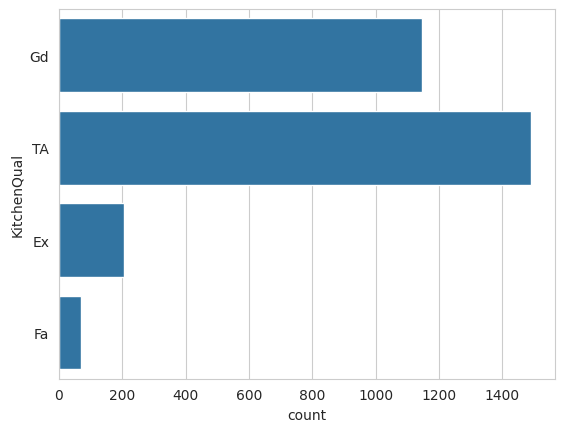

In [131]:
# Visualize the distribution of the 'KitchenQual' feature in the combined dataset using a count plot.
# Explanation:
# - sns.countplot() creates a bar plot showing the frequency of each category in the 'KitchenQual' column.
# - This helps to quickly identify the most common kitchen quality ratings and spot any rare or missing categories.
# - Useful for understanding categorical feature distributions and guiding missing value imputation or encoding.
sns.countplot(conbined_data['KitchenQual'])

In [132]:
# Fill missing values in the 'KitchenQual' column of conbined_data with 'TA'.
# Explanation:
# - 'KitchenQual' (Kitchen quality) has a small number of missing values in both train and test sets.
# - 'TA' (Typical/Average) is the most common value in the dataset for this column.
# - Filling missing values with the most frequent category is a standard approach for categorical features with low missing rates.
# - This ensures consistency and avoids introducing bias from rare categories.
fill_missing_conbined_data('KitchenQual', 'TA')

**SaleType / Functional**

<Axes: xlabel='count', ylabel='Functional'>

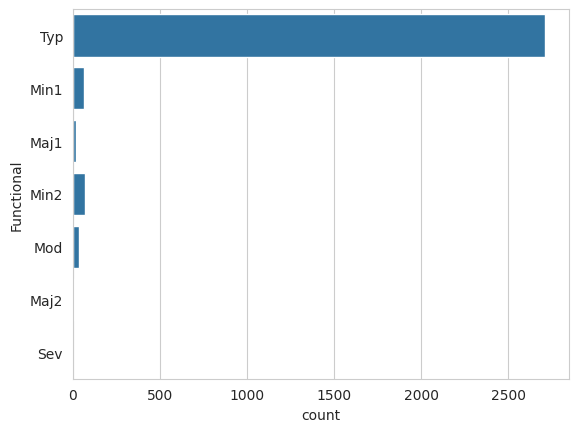

In [133]:
# Visualize the distribution of the 'Functional' feature in the combined dataset using a count plot.
# Explanation:
# - sns.countplot() creates a bar plot showing the frequency of each category in the 'Functional' column.
# - This helps to quickly identify the most common functional ratings and spot any rare or missing categories.
# - Useful for understanding categorical feature distributions and guiding missing value imputation or encoding.
sns.countplot(conbined_data['Functional'])

In [134]:
# Fill missing values in the 'SaleType' column of conbined_data with 'WD'.
# Explanation:
# - 'SaleType' describes the type of sale (e.g., Warranty Deed, etc.).
# - There is only one missing value in the dataset.
# - 'WD' (Warranty Deed) is the most common value, so it's used for imputation.
fill_missing_conbined_data('SaleType', 'WD')

# Fill missing values in the 'Functional' column of conbined_data with 'Typ'.
# Explanation:
# - 'Functional' describes home functionality (e.g., typical, minor issues, etc.).
# - There are only two missing values in the dataset.
# - 'Typ' (Typical functionality) is the most frequent value, so it's used for imputation.
fill_missing_conbined_data('Functional', 'Typ')

Completed missing value imputation.

In [136]:
# Get the column names in conbined_data that have missing values (NaN).
# - conbined_data.isnull().any() returns a boolean Series indicating which columns have any missing values.
# - conbined_data.columns[...] gets the names of those columns.
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()

# For each column with missing data, count the number of missing values.
# - conbined_data[has_null_columns] selects only the columns with missing values.
# - .isnull().sum() counts the number of NaNs in each of those columns.
# - This helps to quickly identify which columns still have missing data and how much is missing.
conbined_data[has_null_columns].isnull().sum()

Series([], dtype: float64)

## 5. 🛠️ Feature Engineering

### 🛠️ Why Feature Engineering is Essential

Feature engineering transforms raw data into meaningful features that improve model performance and interpretability.  
- 🚀 **Boosts Predictive Power:** Carefully crafted features help models capture complex patterns and relationships in the data.
- 🧠 **Incorporates Domain Knowledge:** Custom features reflect real-world insights, making models more relevant and robust.
- 🔍 **Enhances Data Quality:** New features can highlight trends, reduce noise, and address limitations in the original dataset.
- 🏆 **Drives Model Success:** Well-engineered features often make the difference between mediocre and outstanding results.

This section ensures our house price prediction model leverages the full potential of the Ames Housing dataset.

**Time Attributes (YearBuilt, GarageYrBlt)**

In [137]:
# Select rows from conbined_data where 'GarageYrBlt' is not 'NA', and only keep the 'YearBuilt' and 'GarageYrBlt' columns.
# Explanation:
# - conbined_data: The combined dataset containing both train and test data after preprocessing.
# - 'GarageYrBlt' column contains the year the garage was built, but some entries are 'NA' (missing).
# - This line filters out rows where 'GarageYrBlt' is 'NA', so only rows with valid garage build years are kept.
# - The resulting DataFrame, built_year_data, will be used for further analysis or modeling, such as checking correlation or fitting a regression model.
built_year_data = conbined_data[['YearBuilt', 'GarageYrBlt']][conbined_data['GarageYrBlt'] != 'NA']

In [139]:
# Convert the 'GarageYrBlt' column in built_year_data from string/object to integer type.
# Explanation:
# - Some values in 'GarageYrBlt' may be stored as strings (e.g., '1998') due to earlier imputation or merging.
# - Using map(lambda g : int(g)) ensures all values are integers, which is necessary for correlation analysis.
built_year_data['GarageYrBlt'] = built_year_data['GarageYrBlt'].map(lambda g : int(g))

# Calculate the Pearson correlation coefficient between 'GarageYrBlt' and 'YearBuilt'.
# Explanation:
# - .corr() computes the linear correlation between the two columns.
# - A high correlation indicates that the year the garage was built is closely related to the year the house was built.
# - This information is useful for feature engineering and understanding data relationships.
built_year_data['GarageYrBlt'].corr(built_year_data['YearBuilt'])

np.float64(0.8484713519069809)

YearBuilt and GarageYrBlt are highly correlated.

In [140]:
# Display the first row of built_year_data for inspection.
# Explanation:
# - built_year_data contains 'YearBuilt' and 'GarageYrBlt' columns for rows where 'GarageYrBlt' is not 'NA'.
# - Using .head(1) shows the first record, which is useful for verifying the structure and values after filtering and before further analysis.
# - This helps ensure that the data preparation steps for time attributes are correct before proceeding with feature engineering or modeling.
built_year_data.head(1)

,YearBuilt,GarageYrBlt
0,2003,2003


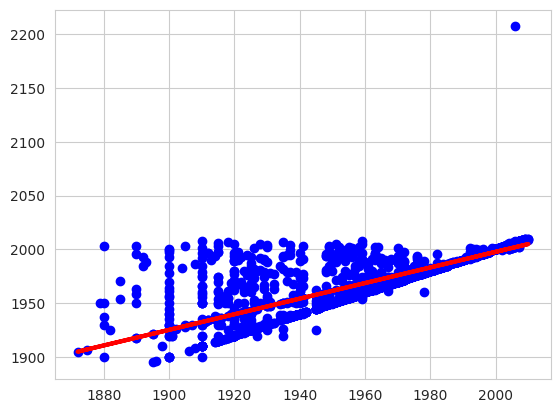

In [141]:
# Import LinearRegression from scikit-learn
from sklearn.linear_model import LinearRegression

# Create a LinearRegression model instance
regr = LinearRegression()

# Extract GarageYrBlt and YearBuilt columns from built_year_data
garage_year = built_year_data.loc[:,'GarageYrBlt'].values
built_year = built_year_data.loc[:,'YearBuilt'].values

# Get the number of samples
length = garage_year.shape[0]

# Reshape arrays to be 2D, as required by scikit-learn
garage_year = garage_year.reshape(length, 1)
built_year = built_year.reshape(length, 1)

# Fit the regression model: predict GarageYrBlt from YearBuilt
regr.fit(built_year, garage_year)

# Plot the data points (YearBuilt vs GarageYrBlt) as blue dots
plt.scatter(built_year, garage_year,  color='blue')

# Plot the regression line (predicted GarageYrBlt) in red
plt.plot(built_year, regr.predict(built_year), color='red',
         linewidth=3)

# Explanation:
# - This code fits a linear regression model to predict the year the garage was built (GarageYrBlt)
#   based on the year the house was built (YearBuilt), using only rows where GarageYrBlt is not 'NA'.
# - The scatter plot visualizes the actual data points, and the red line shows the fitted regression.
# - This model will be used to impute missing GarageYrBlt values later, based on YearBuilt.

In [142]:
# Fill NA values in GarageYrBlt using the regression model
# Explanation:
# - This code replaces 'NA' values in the 'GarageYrBlt' column of conbined_data with predicted values from a linear regression model.
# - For each row, if 'GarageYrBlt' is 'NA', it uses the trained regression model (regr) to predict the garage build year based on 'YearBuilt'.
# - The prediction is made by passing the 'YearBuilt' value as input to regr.predict, and the result is converted to an integer.
# - If 'GarageYrBlt' is not 'NA', it simply converts the existing value to an integer.
# - The operation is applied row-wise (axis=1) using DataFrame.apply.
conbined_data['GarageYrBlt'] = conbined_data.apply(
    lambda row: int(regr.predict(np.array([[row['YearBuilt']]]))[0]) if row['GarageYrBlt'] == 'NA' else int(row['GarageYrBlt']),
    axis=1
)

In [143]:
# Display the first 5 values of the 'GarageYrBlt' column in conbined_data.
# Explanation:
# - conbined_data['GarageYrBlt'] contains the year the garage was built for each record in the combined dataset.
# - .head() returns the first 5 entries, which is useful for quickly inspecting the results of previous feature engineering steps.
# - This helps verify that missing values have been imputed and that the column is correctly formatted as integers.
conbined_data['GarageYrBlt'].head()

0    2003
1    1976
2    2001
3    1998
4    2000
Name: GarageYrBlt, dtype: int64

YearBuilt: Year the house was built  
YearRemodAdd: Year the house was remodeled  
Used to determine whether the house has been renovated

In [144]:
# How many years has remoded from built
# Calculate the number of years between when the house was built and when it was remodeled.
# This feature (RemodYears) helps capture how long after construction a renovation occurred.
conbined_data['RemodYears'] = conbined_data['YearRemodAdd'] - conbined_data['YearBuilt']

# Did a remodeling happened from built?
# Create a binary feature (HasRemodeled) indicating whether the house has ever been remodeled.
# If YearRemodAdd is different from YearBuilt, set to 1 (remodeled), else 0 (not remodeled).
conbined_data["HasRemodeled"] = (conbined_data["YearRemodAdd"] != conbined_data["YearBuilt"]) * 1

# Did a remodeling happen in the year the house was sold?
# Create a binary feature (HasRecentRemodel) indicating if the remodeling occurred in the year of sale.
# If YearRemodAdd equals YrSold, set to 1 (recent remodel), else 0.
conbined_data["HasRecentRemodel"] = (conbined_data["YearRemodAdd"] == conbined_data["YrSold"]) * 1

In [145]:
# Calculate the number of years between when the garage was built and when the house was built.
# Explanation:
# - conbined_data['GarageYrBlt']: The year the garage was built (after missing value imputation).
# - conbined_data['YearBuilt']: The year the house was built.
# - Subtracting YearBuilt from GarageYrBlt gives the number of years after the house was built that the garage was added.
# - If the garage was built in the same year as the house, the result is 0.
# - This feature (GarageBltYears) helps capture whether the garage is original or added later, which may affect house value.
conbined_data['GarageBltYears'] = conbined_data['GarageYrBlt'] - conbined_data['YearBuilt']

In [146]:
# Display the first 5 values of the 'GarageBltYears' column in conbined_data.
# Explanation:
# - conbined_data['GarageBltYears'] contains the difference between the year the garage was built and the year the house was built.
# - .head() returns the first 5 entries, which is useful for quickly inspecting the results of previous feature engineering steps.
# - This helps verify that the feature was calculated correctly and provides insight into how often garages are built at the same time as the house or added later.
conbined_data['GarageBltYears'].head()

0     0
1     0
2     0
3    83
4     0
Name: GarageBltYears, dtype: int64

In [147]:
# How many years has build now?
# Explanation:
# - This block creates three new features in conbined_data, each representing how many years ago a key event happened (relative to 2017).
# - 'Now_YearBuilt': Number of years since the house was built (2017 - YearBuilt).
# - 'Now_YearRemodAdd': Number of years since the house was remodeled (2017 - YearRemodAdd).
# - 'Now_GarageYrBlt': Number of years since the garage was built (2017 - GarageYrBlt).
# - These features help capture the "age" of the house, its last remodel, and the garage, which are often important predictors for house price.
conbined_data['Now_YearBuilt'] = 2017 - conbined_data['YearBuilt']
conbined_data['Now_YearRemodAdd'] = 2017 - conbined_data['YearRemodAdd']
conbined_data['Now_GarageYrBlt'] = 2017 - conbined_data['GarageYrBlt']

In [148]:
# Display the first 3 rows of the engineered time-based features:
# - 'Now_YearBuilt': Number of years since the house was built (2017 - YearBuilt)
# - 'Now_YearRemodAdd': Number of years since the house was remodeled (2017 - YearRemodAdd)
# - 'Now_GarageYrBlt': Number of years since the garage was built (2017 - GarageYrBlt)
# These features help capture the "age" of the house, its last remodel, and the garage,
# which are important predictors for house price.
conbined_data[['Now_YearBuilt','Now_YearRemodAdd','Now_GarageYrBlt']].head(3)

,Now_YearBuilt,Now_YearRemodAdd,Now_GarageYrBlt
0,14,14,14
1,41,41,41
2,16,15,16


- There is a peak season for house sales by month
- The month in which the house is sold is a numeric type, so it is converted to a string type

<Axes: xlabel='MoSold'>

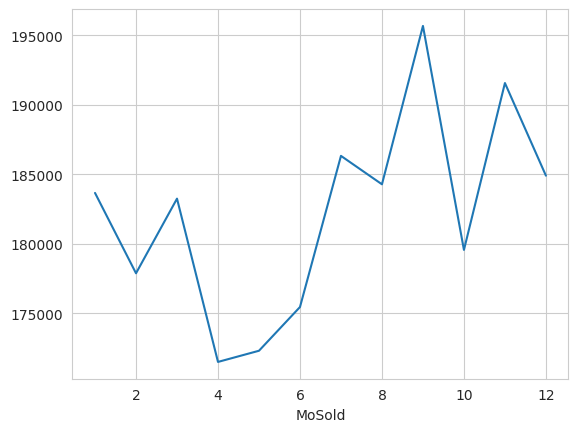

In [149]:
# Plot the average SalePrice for each month the house was sold.
# Explanation:
# - train_data['SalePrice']: The target variable (house price) from the training set.
# - groupby(train_data['MoSold']): Groups the SalePrice values by the month sold (MoSold).
# - mean(): Calculates the mean SalePrice for each month.
# - plot(): Plots the resulting monthly average SalePrice as a line plot.
# - This visualization helps identify seasonal trends in house prices, showing which months tend to have higher or lower average sale prices.
train_data['SalePrice'].groupby(train_data['MoSold']).mean().plot()

<Axes: xlabel='count', ylabel='MoSold'>

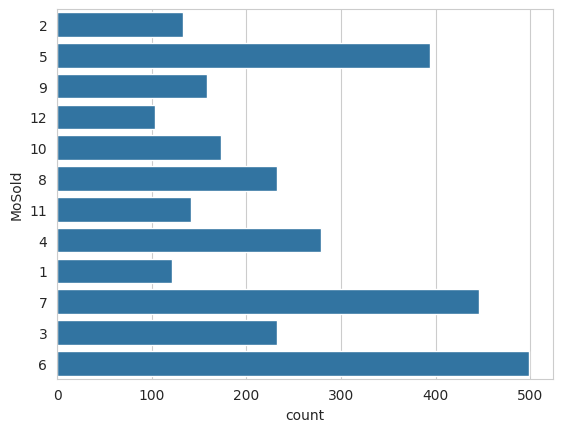

In [150]:
# Visualize the distribution of house sales by month using a count plot.
# Explanation:
# - sns.countplot() creates a bar plot showing the number of houses sold in each month ('MoSold').
# - conbined_data['MoSold'] contains the month (as a string) when each house was sold.
# - This plot helps identify seasonal patterns in house sales, such as peak and low sales months.
# - Useful for feature engineering and understanding how sale timing may affect price or volume.
sns.countplot(conbined_data['MoSold'])

The number of houses sold each month and the average price are basically inversely proportional.

In [151]:
# Calculate the average SalePrice for each month sold in the training data.
# Explanation:
# - train_data['SalePrice']: The target variable (house price) from the training set.
# - groupby(train_data['MoSold']): Groups the SalePrice values by the month sold (MoSold).
# - mean(): Calculates the mean SalePrice for each month.
# - to_dict(): Converts the result to a dictionary mapping month to average price.
sale_price_month = train_data['SalePrice'].groupby(train_data['MoSold']).mean().to_dict()

# Map the average sale price for each month to the combined dataset.
# Explanation:
# - conbined_data["MoSold"]: The month each house was sold (as a string).
# - .replace(sale_price_month): Replaces each month value with its corresponding average SalePrice from the dictionary.
# - The new feature "MonthSaledMeanPrice" represents the average sale price for the month in which each house was sold.
conbined_data["MonthSaledMeanPrice"] = conbined_data["MoSold"].replace(sale_price_month)


In [152]:
# Count the number of sales per month.
# Explanation:
# - sale_month is initialized as a dictionary with keys as string representations of months ("1" to "12"), all set to 0.
# - The for loop iterates over all values in the 'MoSold' column of conbined_data.
# - For each month value m, it is converted to a string and used as a key to increment the corresponding count in sale_month.
# - This results in sale_month containing the total number of sales for each month, which can be used for feature engineering or analysis.
sale_month = {"1": 0, "2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "11": 0, "12": 0}
for m in conbined_data['MoSold'].values:
    sale_month[str(m)] = sale_month[str(m)] + 1

In [153]:
# Convert month from numeric type to string type
# Explanation:
# - conbined_data['MoSold'] contains the month each house was sold, currently as an integer (e.g., 1, 2, ..., 12).
# - The .map(lambda m: str(m)) function converts each integer month value to a string (e.g., '1', '2', ..., '12').
# - This is useful for categorical encoding, plotting, or feature engineering where months are treated as categories rather than numbers.
conbined_data['MoSold'] = conbined_data['MoSold'].map(lambda m: str(m))

In [154]:
# Number of sales in each month
# Explanation:
# - sale_month is a dictionary where keys are string representations of months ("1" to "12") and values are the number of sales in each month.
# - conbined_data["MoSold"] contains the month each house was sold, as a string.
# - .replace(sale_month) maps each month in "MoSold" to its corresponding count from sale_month.
# - The result is a new feature "MonthSaledCount" in conbined_data, representing the total number of sales for the month in which each house was sold.
conbined_data["MonthSaledCount"] = conbined_data["MoSold"].replace(sale_month)

**The numerical value of MSSubClass only represents the type of dwelling, so it is encoded.**

<Axes: xlabel='MSSubClass'>

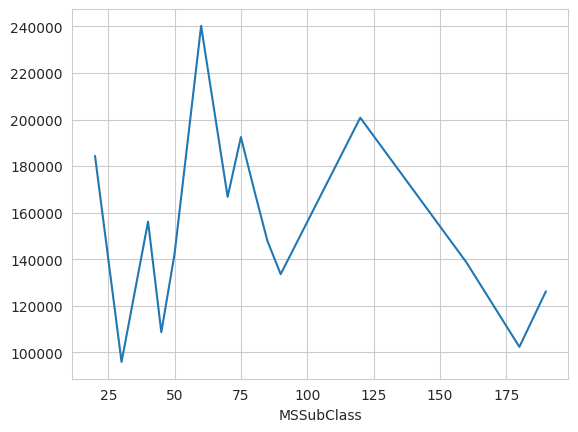

In [155]:
# Plot the average SalePrice for each MSSubClass category in the training data.
# Explanation:
# - train_data['SalePrice']: The target variable (house price) from the training set.
# - groupby(train_data['MSSubClass']): Groups the SalePrice values by the MSSubClass (building class/type).
# - mean(): Calculates the mean SalePrice for each MSSubClass category.
# - plot(): Plots the resulting average SalePrice for each MSSubClass as a line plot.
# - This visualization helps to identify how house prices vary by dwelling type, showing which building classes tend to have higher or lower average sale prices.
train_data['SalePrice'].groupby(train_data['MSSubClass']).mean().plot()

<Axes: xlabel='count', ylabel='MSSubClass'>

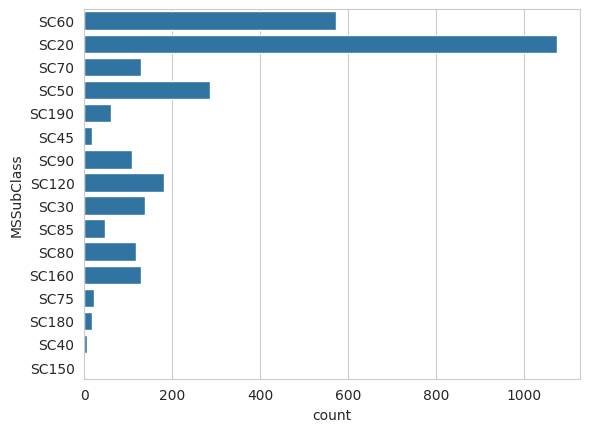

In [156]:
# Visualize the distribution of the 'MSSubClass' feature in the combined dataset using a count plot.
# Explanation:
# - sns.countplot() creates a bar plot showing the frequency of each category in the 'MSSubClass' column.
# - conbined_data['MSSubClass'] contains the building class/type for each house.
# - This plot helps to quickly identify which dwelling types are most common and spot any rare categories.
# - Useful for understanding categorical feature distributions and guiding feature engineering or encoding.
sns.countplot(conbined_data['MSSubClass'])

It can be seen that both price and sales volume are related to MSSubClass. According to the data description, this is because of whether the house is NEWER!

In [157]:
# Add a new feature "NewerDwelling" to conbined_data based on MSSubClass.
# Explanation:
# - MSSubClass is a categorical variable representing the type of dwelling.
# - Certain MSSubClass values (20, 60, 120) are considered "newer" types of dwellings and are mapped to 1.
# - All other MSSubClass values are mapped to 0, indicating older dwelling types.
# - The mapping is applied using .replace(), which substitutes the specified values in the MSSubClass column.
# - This feature helps distinguish between newer and older house types, which can be useful for modeling house prices.
conbined_data["NewerDwelling"] = conbined_data["MSSubClass"].replace(
    {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
     90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})

In [158]:
# Add the average price for each category
# Explanation:
# - train_data['SalePrice']: The target variable (house price) from the training set.
# - groupby(train_data['MSSubClass']): Groups the SalePrice values by the MSSubClass (building class/type).
# - mean(): Calculates the mean SalePrice for each MSSubClass category.
# - to_dict(): Converts the result to a dictionary mapping MSSubClass to average price.
sale_price_mssc = train_data['SalePrice'].groupby(train_data['MSSubClass']).mean().to_dict()

# Average price sold for each category
# Explanation:
# - conbined_data["MSSubClass"]: The MSSubClass value for each record in the combined dataset.
# - .replace(sale_price_mssc): Replaces each MSSubClass value with its corresponding average SalePrice from the dictionary.
# - The new feature "MSSubClassMeanPrice" represents the average sale price for the MSSubClass of each house.
conbined_data["MSSubClassMeanPrice"] = conbined_data["MSSubClass"].replace(sale_price_mssc)

In [160]:
# Create a mapping dictionary to encode MSSubClass values as strings.
# Explanation:
# - MSSubClass is a categorical feature represented by integers (e.g., 20, 30, 40, ...).
# - For modeling and feature engineering, it's common to convert these to string codes (e.g., 'SC20', 'SC30', ...).
# - This helps treat MSSubClass as a categorical variable rather than a numeric one, preventing unintended ordinal relationships.
mssubclass_dict = {
    20: 'SC20',
    30: 'SC30',
    40: 'SC40',
    45: 'SC45',
    50: 'SC50',
    60: 'SC60',
    70: 'SC70',
    75: 'SC75',
    80: 'SC80',
    85: 'SC85',
    90: 'SC90',
    120: 'SC120',
    150: 'SC150',
    160: 'SC160',
    180: 'SC180',
    190: 'SC190',
}

# Replace the integer MSSubClass values in conbined_data with their corresponding string codes.
# Explanation:
# - conbined_data['MSSubClass'] contains the original integer values.
# - .replace(mssubclass_dict) substitutes each integer with its mapped string code.
# - This transformation is useful for downstream encoding (e.g., one-hot encoding) and improves model interpretability.
conbined_data['MSSubClass'] = conbined_data['MSSubClass'].replace(mssubclass_dict)

For attributes that have ordinal or quality levels, encode them accordingly.

In [161]:
# Mapping dictionary for ordinal and quality features.
# Explanation:
# - good_level_map defines how to convert categorical values to ordinal numeric values for various features.
# - Each key is a column name, and its value is a dictionary mapping category to integer.
# - This is useful for features where the order or quality level matters (e.g., 'ExterQual', 'BsmtQual', etc.).
good_level_map = {'Street': {'Grvl': 0, 'Pave': 1},
    'Alley': {'NA':0, 'Grvl': 1, 'Pave': 2},
    'Utilities': {'AllPub':3, 'NoSeWa': 1, 'NoSewr': 2, 'ELO': 0},
    'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
    'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1,'NA': 0},
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2,'Po': 1,'NA': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2,'Po': 1,'NA': 0},
    'BsmtFinType1': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
    'BsmtFinType2': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
    'HeatingQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
    'CentralAir': {'N':0, 'Y':1},
    'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'Functional': {'Typ':0,'Min1':1,'Min2':1,'Mod':2,'Maj1':3,'Maj2':4,'Sev':5,'Sal': 6},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NA': 0},
    'Fence': {'GdPrv': 2, 'GdWo': 2, 'MnPrv': 1, 'MnWw': 1, 'NA': 0}
    }

print(good_level_map.keys())  # Print the keys (column names) that will be mapped.

# Select columns from conbined_data that are in good_level_map and replace their values using the mapping.
# Explanation:
# - conbined_data[good_level_map.keys()] selects only the relevant columns.
# - .replace(good_level_map) applies the mapping to convert categorical values to ordinal integers.
good_level_data = conbined_data[good_level_map.keys()].replace(good_level_map)

# Rename columns by adding an underscore at the end.
# Explanation:
# - This helps distinguish the newly encoded columns from the originals.
# - .map(lambda m : m + '_') appends '_' to each column name.
good_level_data.columns = good_level_data.columns.map(lambda m : m + '_')

# Assign the encoded columns back to conbined_data.
# Explanation:
# - This adds the new ordinal columns to the main dataframe, preserving the original columns.
conbined_data[good_level_data.columns] = good_level_data[good_level_data.columns]

print (conbined_data.shape)  # Print the shape of the updated dataframe to confirm changes.

dict_keys(['Street', 'Alley', 'Utilities', 'ExterQual', 'ExterCond', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'])
(2911, 149)


Neighborhood 属性表示的是附近的地名，可将其转为经纬度。

In [162]:
# Map latitude values to each Neighborhood in conbined_data.
# Explanation:
# - conbined_data["Neighborhood"] contains the neighborhood name for each house.
# - .replace({...}) maps each neighborhood to its corresponding latitude value.
# - This creates a new column "latitude" with the latitude for each house based on its neighborhood.
conbined_data["latitude"] = conbined_data.Neighborhood.replace(
                                               {'Blmngtn' : 42.062806,
                                                'Blueste' : 42.009408,
                                                'BrDale' : 42.052500,
                                                'BrkSide': 42.033590,
                                                'ClearCr': 42.025425,
                                                'CollgCr': 42.021051,
                                                'Crawfor': 42.025949,
                                                'Edwards': 42.022800,
                                                'Gilbert': 42.027885,
                                                'GrnHill': 42.000854,
                                                'IDOTRR' : 42.019208,
                                                'Landmrk': 42.044777,
                                                'MeadowV': 41.991866,
                                                'Mitchel': 42.031307,
                                                'NAmes'  : 42.042966,
                                                'NoRidge': 42.050307,
                                                'NPkVill': 42.050207,
                                                'NridgHt': 42.060356,
                                                'NWAmes' : 42.051321,
                                                'OldTown': 42.028863,
                                                'SWISU'  : 42.017578,
                                                'Sawyer' : 42.033611,
                                                'SawyerW': 42.035540,
                                                'Somerst': 42.052191,
                                                'StoneBr': 42.060752,
                                                'Timber' : 41.998132,
                                                'Veenker': 42.040106})

# Map longitude values to each Neighborhood in conbined_data.
# Explanation:
# - Similar to latitude, this maps each neighborhood to its longitude value.
# - The new column "longitude" contains the longitude for each house based on its neighborhood.
conbined_data["longitude"] = conbined_data.Neighborhood.replace(
                                               {'Blmngtn' : -93.639963,
                                                'Blueste' : -93.645543,
                                                'BrDale' : -93.628821,
                                                'BrkSide': -93.627552,
                                                'ClearCr': -93.675741,
                                                'CollgCr': -93.685643,
                                                'Crawfor': -93.620215,
                                                'Edwards': -93.663040,
                                                'Gilbert': -93.615692,
                                                'GrnHill': -93.643377,
                                                'IDOTRR' : -93.623401,
                                                'Landmrk': -93.646239,
                                                'MeadowV': -93.602441,
                                                'Mitchel': -93.626967,
                                                'NAmes'  : -93.613556,
                                                'NoRidge': -93.656045,
                                                'NPkVill': -93.625827,
                                                'NridgHt': -93.657107,
                                                'NWAmes' : -93.633798,
                                                'OldTown': -93.615497,
                                                'SWISU'  : -93.651283,
                                                'Sawyer' : -93.669348,
                                                'SawyerW': -93.685131,
                                                'Somerst': -93.643479,
                                                'StoneBr': -93.628955,
                                                'Timber' : -93.648335,
                                                'Veenker': -93.657032})

# Calculate the Euclidean distance from each house to the center of Ames city.
# Explanation:
# - Ames city center coordinates: longitude -93.63191310000002, latitude 42.0307812.
# - For each house, subtract the city center coordinates from its longitude and latitude, square the differences, sum them, and take the square root.
# - This gives the straight-line distance from the house to the city center, which can be useful for modeling location effects.
conbined_data["NeighborDistance"] = np.sqrt(np.power((conbined_data["longitude"] - (-93.63191310000002)),2) + \
                                    np.power((conbined_data["latitude"] - 42.0307812),2))

# Display the first 5 values of the calculated NeighborDistance for inspection.
display(conbined_data["NeighborDistance"].head())

# Remove the temporary longitude and latitude columns from conbined_data.
# Explanation:
# - These columns were only needed for distance calculation and are not required for further analysis.
conbined_data.drop(['longitude', 'latitude'], axis=1, inplace=True)

0    0.054604
1    0.026794
2    0.054604
3    0.012657
4    0.031042
Name: NeighborDistance, dtype: float64

In [ ]:
# Bin by neighborhood (a little arbitrarily).
# Explanation:
# - This code creates a mapping from each neighborhood to its median SalePrice in the training data.
# - train_data["SalePrice"].groupby(train_data["Neighborhood"]) groups SalePrice values by Neighborhood.
# - .median() computes the median SalePrice for each neighborhood.
# - .sort_values() sorts the neighborhoods by their median SalePrice in ascending order.
# - .to_dict() converts the sorted Series to a dictionary, where keys are neighborhood names and values are the corresponding median prices.
# - neighbor_price_map can be used for feature engineering, such as assigning a price bin or encoding neighborhoods by their typical price level.
neighbor_price_map = train_data["SalePrice"].groupby(train_data["Neighborhood"]).median().sort_values().to_dict()

In [163]:
# neighbor_bin_map: Dictionary mapping each Neighborhood to a price bin (0-4).
# Explanation:
# - Each key is a neighborhood name, and its value is an integer bin representing the typical price level.
# - The bins are assigned based on the median SalePrice for each neighborhood (see neighbor_price_map).
# - Lower bin numbers correspond to lower-priced neighborhoods, higher bins to higher-priced ones.
neighbor_bin_map = {
    "MeadowV" : 0,  #  88000
    "IDOTRR" : 1,   # 103000
    "BrDale" : 1,   # 106000
    "OldTown" : 1,  # 119000
    "Edwards" : 1,  # 119500
    "BrkSide" : 1,  # 124300
    "Sawyer" : 1,   # 135000
    "Blueste" : 1,  # 137500
    "SWISU" : 2,    # 139500
    "NAmes" : 2,    # 140000
    "NPkVill" : 2,  # 146000
    "Mitchel" : 2,  # 153500
    "SawyerW" : 2,  # 179900
    "Gilbert" : 2,  # 181000
    "NWAmes" : 2,   # 182900
    "Blmngtn" : 2,  # 191000
    "CollgCr" : 2,  # 197200
    "ClearCr" : 3,  # 200250
    "Crawfor" : 3,  # 200624
    "Veenker" : 3,  # 218000
    "Somerst" : 3,  # 225500
    "Timber" : 3,   # 228475
    "StoneBr" : 4,  # 278000
    "NoRidge" : 4,  # 290000
    "NridgHt" : 4,  # 315000
}

# Map the median SalePrice for each Neighborhood to the "NeighborPrice" column in conbined_data.
# Explanation:
# - neighbor_price_map: Dictionary mapping neighborhood names to their median SalePrice (from train_data).
# - conbined_data["Neighborhood"].map(neighbor_price_map) assigns the median price to each record based on its neighborhood.
# - This feature captures the typical price level for each neighborhood, useful for modeling.
conbined_data["NeighborPrice"] = conbined_data["Neighborhood"].map(neighbor_price_map)

# Map the price bin for each Neighborhood to the "NeighborBin" column in conbined_data.
# Explanation:
# - neighbor_bin_map: Dictionary mapping neighborhood names to price bins (0-4).
# - conbined_data["Neighborhood"].map(neighbor_bin_map) assigns the bin to each record based on its neighborhood.
# - This feature provides a categorical representation of neighborhood price levels for downstream analysis or modeling.
conbined_data["NeighborBin"] = conbined_data["Neighborhood"].map(neighbor_bin_map)

In [165]:
# Display the first 5 rows of the combined dataset (conbined_data).
# Explanation:
# - conbined_data contains both the training and test data after preprocessing and feature engineering.
# - .head() returns the first 5 records, which is useful for quickly inspecting the structure and values of the dataset.
# - This helps verify that all previous steps (missing value imputation, feature engineering, encoding, etc.) have been applied correctly.
conbined_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageGrade,ExterGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,TotalBath,TotalPorchSF,AllSF,BoughtOffPlan
0,1,SC60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,TATATA,TATATA,3,0,1644.0,0,3.5,61,2627.0,0
1,2,SC20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,TATATA,TATA,2,3,1380.0,0,2.5,0,2822.0,0
2,3,SC60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,TATATA,TATATA,3,3,1824.0,0,3.5,42,2748.0,0
3,4,SC70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,...,TATATA,TATA,3,4,1926.0,0,2.0,307,2780.0,0
4,5,SC60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,...,TATATA,TATATA,3,3,2508.0,0,3.5,84,3619.0,0


Ref: [juliencs : A study on Regression applied to the Ames dataset
](https://www.kaggle.com/juliencs/house-prices-advanced-regression-techniques/a-study-on-regression-applied-to-the-ames-dataset)
- Create some boolean features
- Simplifications of existing features - Ref
- Combinations of existing features - Ref
- Polynomials on the top 10 existing features - Ref

In [167]:
# Get all columns in conbined_data with string (object) dtype.
# - select_dtypes(include=['object']) selects columns where the data type is 'object', typically used for categorical or text data.
# - .columns.values returns the column names as a numpy array.
str_columns = conbined_data.select_dtypes(include=['object']).columns.values

# Get all columns in conbined_data with numeric dtype (excluding 'object').
# - select_dtypes(exclude=['object']) selects columns with numeric types (int, float, etc.).
# - .columns.values returns the column names as a numpy array.
num_columns = conbined_data.select_dtypes(exclude=['object']).columns.values

In [169]:
# str_columns contains all columns in conbined_data with string (object) dtype.
# - select_dtypes(include=['object']) selects columns where the data type is 'object', typically used for categorical or text data.
# - .columns.values returns the column names as a numpy array.
# - This is useful for identifying which columns need encoding or special handling during feature engineering.
str_columns

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'MoSold', 'SaleType', 'SaleCondition', 'MonthSaledMeanPrice',
       'NewerDwelling', 'MSSubClassMeanPrice', 'GarageGrade',
       'ExterGrade'], dtype=object)

1.Create some boolean features

['Normal' 'Partial' 'Abnorml' 'Family' 'Alloca' 'AdjLand']


<Axes: xlabel='count', ylabel='SaleCondition'>

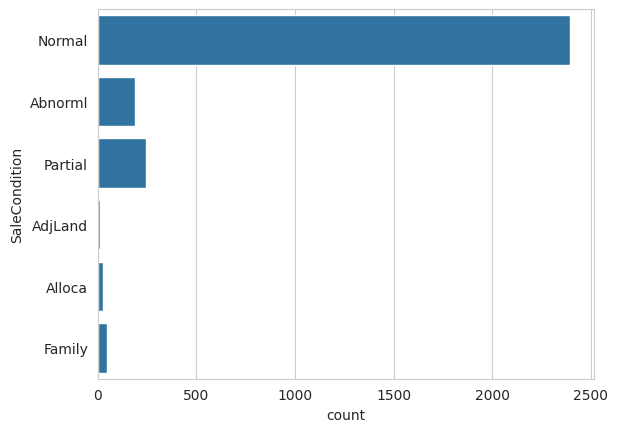

In [171]:
# test str column
# This block analyzes the distribution of values in a string (categorical) column of conbined_data.
column = "SaleCondition"  # The column to analyze (can be changed to any string column)
count_duct = {}  # Initialize an empty dictionary to store counts for each unique value

# Iterate over all unique values in the column and initialize their count to 0
for key in set(conbined_data[column]):
    count_duct[key] = 0
    
# Count the occurrences of each value in the column
for m in conbined_data[column].values:
    count_duct[str(m)] = count_duct[str(m)] + 1

# Sort the dictionary items by count in descending order
count_duct = sorted(count_duct.items(), key=lambda d: d[1], reverse=True)

# Print the unique values in the column, sorted by frequency
print(np.array(count_duct)[:, 0])

# Visualize the distribution of the column using a count plot
# This helps to quickly see the frequency of each category
sns.countplot(conbined_data[column])

In [172]:
# Create boolean features for common categories in several columns.
# Explanation:
# - For each feature, create a new column that is 1 if the condition is met, 0 otherwise.
# - This helps simplify categorical variables and highlight important distinctions for modeling.

# LotShape: Distinguish regular ("Reg") from irregular lot shapes.
conbined_data["IsRegularLotShape"] = (conbined_data["LotShape"] == "Reg") * 1

# LandContour: Distinguish level ("Lvl") land contour from others.
conbined_data["IsLandContourLvl"] = (conbined_data["LandContour"] == "Lvl") * 1

# LotConfig: Distinguish "Inside" lot configuration from others.
conbined_data["IsLotConfigInside"] = (conbined_data["LotConfig"] == "Inside") * 1

# LandSlope: Distinguish gentle ("Gtl") slope from others.
conbined_data["IsLandSlopeGentle"] = (conbined_data["LandSlope"] == "Gtl") * 1

# Condition1: Distinguish normal ("Norm") condition from others.
conbined_data["IsCondition1Norm"] = (conbined_data["Condition1"] == "Norm") * 1

# Condition2: Distinguish normal ("Norm") condition from others.
conbined_data["IsCondition2Norm"] = (conbined_data["Condition2"] == "Norm") * 1

# BldgType: Distinguish single-family ("1Fam") building type from others.
conbined_data["IsBldgType1Fam"] = (conbined_data["BldgType"] == "1Fam") * 1

# RoofStyle: Distinguish gable ("Gable") roof style from others.
conbined_data["IsRoofStyleGable"] = (conbined_data["RoofStyle"] == "Gable") * 1

# RoofMatl: Distinguish composition shingle ("CompShg") roof material from others.
conbined_data["IsRoofMatlCompShg"] = (conbined_data["RoofMatl"] == "CompShg") * 1

# Heating: Distinguish gas forced air ("GasA") heating from others.
conbined_data["IsGasAHeating"] = (conbined_data["Heating"] == "GasA") * 1

# GarageFinish: Distinguish finished ("Fin") garage from others.
conbined_data["IsGarageFinished"] = (conbined_data["GarageFinish"] == "Fin") * 1

# PavedDrive: Distinguish paved drive ("Y") from others.
conbined_data["IsPavedDrive"] = (conbined_data["PavedDrive"] == "Y") * 1

# SaleType: Distinguish warranty deed ("WD") sale type from others.
conbined_data["IsSaleTypeWD"] = (conbined_data["SaleType"] == "WD") * 1

# SaleCondition: Distinguish normal ("Normal") sale condition from others.
conbined_data["IsSaleConditionNormal"] = (conbined_data["SaleCondition"] == "Normal") * 1

In [173]:
# The only interesting "misc. feature" is the presence of a shed.
# Explanation:
# - conbined_data["MiscFeature"] contains miscellaneous features for each house.
# - This line creates a new boolean feature "HasShed" that is 1 if MiscFeature is "Shed", otherwise 0.
# - Useful for modeling, as sheds may add value or utility to a property.
conbined_data["HasShed"] = (conbined_data["MiscFeature"] == "Shed") * 1.  

# Was this house sold in the year it was built?
# Explanation:
# - Checks if the house was sold in the same year it was built.
# - "IsVeryNewHouse" is 1 if YearBuilt equals YrSold, otherwise 0.
# - Indicates properties that were sold as new constructions.
conbined_data["IsVeryNewHouse"] = (conbined_data["YearBuilt"] == conbined_data["YrSold"]) * 1

# Create boolean features for the presence/absence of certain house attributes.
# Explanation:
# - Each feature below is 1 if the corresponding area is zero (i.e., the house does NOT have that feature), otherwise 0.
# - These features help the model distinguish houses with/without these amenities.

conbined_data["Has2ndFloor"] = (conbined_data["2ndFlrSF"] == 0) * 1      # No second floor
conbined_data["HasMasVnr"] = (conbined_data["MasVnrArea"] == 0) * 1      # No masonry veneer
conbined_data["HasWoodDeck"] = (conbined_data["WoodDeckSF"] == 0) * 1    # No wood deck
conbined_data["HasOpenPorch"] = (conbined_data["OpenPorchSF"] == 0) * 1  # No open porch
conbined_data["HasEnclosedPorch"] = (conbined_data["EnclosedPorch"] == 0) * 1  # No enclosed porch
conbined_data["Has3SsnPorch"] = (conbined_data["3SsnPorch"] == 0) * 1    # No 3-season porch
conbined_data["HasScreenPorch"] = (conbined_data["ScreenPorch"] == 0) * 1  # No screened porch

In [174]:
# 2.Simplifications of existing features

# Simplify the 'OverallQual' (overall material and finish quality) feature into three categories:
# - 1: bad (original values 1, 2, 3)
# - 2: average (original values 4, 5, 6)
# - 3: good (original values 7, 8, 9, 10)
# This reduces the granularity of the feature, making it easier for models to capture broad quality distinctions.
conbined_data["SimplOverallQual"] = conbined_data.OverallQual.replace(
    {1 : 1, 2 : 1, 3 : 1,      # bad
     4 : 2, 5 : 2, 6 : 2,      # average
     7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
    })

# Simplify the 'OverallCond' (overall condition rating) feature into three categories:
# - 1: bad (original values 1, 2, 3)
# - 2: average (original values 4, 5, 6)
# - 3: good (original values 7, 8, 9, 10)
# This helps to reduce noise and focus on major condition differences for modeling.
conbined_data["SimplOverallCond"] = conbined_data.OverallCond.replace(
    {1 : 1, 2 : 1, 3 : 1,      # bad
     4 : 2, 5 : 2, 6 : 2,      # average
     7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
    })

In [176]:
# 3.Combinations of existing features

# Overall quality of the house
# - Multiplies 'OverallQual' (overall material/finish quality) by 'OverallCond' (overall condition rating).
# - Creates a composite score capturing both quality and condition.
conbined_data["OverallGrade"] = conbined_data["OverallQual"] * conbined_data["OverallCond"]

# Overall quality of the garage
# - Multiplies encoded garage quality ('GarageQual_') by garage condition ('GarageCond').
# - Highlights garages that are both high quality and well maintained.
conbined_data["GarageGrade"] = conbined_data["GarageQual_"] * conbined_data["GarageCond"]

# Overall quality of the exterior
# - Multiplies encoded exterior quality ('ExterQual_') by exterior condition ('ExterCond').
# - Captures the combined effect of exterior materials and their condition.
conbined_data["ExterGrade"] = conbined_data["ExterQual_"] * conbined_data["ExterCond"]

# Overall kitchen score
# - Multiplies number of kitchens above ground ('KitchenAbvGr') by encoded kitchen quality ('KitchenQual_').
# - Useful for distinguishing homes with multiple kitchens or higher kitchen quality.
conbined_data["KitchenScore"] = conbined_data["KitchenAbvGr"] * conbined_data["KitchenQual_"]

# Overall fireplace score
# - Multiplies number of fireplaces ('Fireplaces') by encoded fireplace quality ('FireplaceQu_').
# - Highlights homes with more and/or better fireplaces.
conbined_data["FireplaceScore"] = conbined_data["Fireplaces"] * conbined_data["FireplaceQu_"]

# Overall garage score
# - Multiplies garage area ('GarageArea') by encoded garage quality ('GarageQual_').
# - Captures both the size and quality of the garage.
conbined_data["GarageScore"] = conbined_data["GarageArea"] * conbined_data["GarageQual_"]

# Overall pool score
# - Multiplies pool area ('PoolArea') by encoded pool quality ('PoolQC_').
# - Useful for distinguishing homes with larger and/or higher quality pools.
conbined_data["PoolScore"] = conbined_data["PoolArea"] * conbined_data["PoolQC_"]

# Total number of bathrooms
# - Sums basement full baths, half baths (weighted by 0.5), full baths, and half baths.
# - Provides a single feature representing total bathroom count.
conbined_data["TotalBath"] = conbined_data["BsmtFullBath"] + (0.5 * conbined_data["BsmtHalfBath"]) + \
conbined_data["FullBath"] + (0.5 * conbined_data["HalfBath"])

# Total yard area in square feet
# - Sums open porch, enclosed porch, 3-season porch, and screen porch areas.
# - Captures total outdoor/porch space.
conbined_data["TotalPorchSF"] = conbined_data["OpenPorchSF"] + conbined_data["EnclosedPorch"] +\
                                conbined_data["3SsnPorch"] + conbined_data["ScreenPorch"]

# Total SF for house (living, basement, porch, pool)
# - Sums living area, basement area, porch area, wood deck, and pool area.
# - Provides a comprehensive measure of total usable space.
conbined_data["AllSF"] = conbined_data["GrLivArea"] + conbined_data["TotalBsmtSF"] + \
                         conbined_data["TotalPorchSF"] + conbined_data["WoodDeckSF"] + \
                         conbined_data["PoolArea"]

# House completed before sale or not
# - Encodes whether the house was bought off-plan ('Partial' SaleCondition = 1, others = 0).
# - Useful for identifying new builds sold before completion.
conbined_data["BoughtOffPlan"] = conbined_data.SaleCondition.replace(
    {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})

In [189]:
# 4.Polynomials on the top n existing features
# Explanation:
# - This section is intended for generating polynomial features (e.g., squares, cubes, interactions) from the top n features.
# - Polynomial features can help capture non-linear relationships in the data and improve model performance.
# - The code below prepares the training data for this purpose.

train_data_new = conbined_data.iloc[:train_length,:]  # Select the first train_length rows from conbined_data as the new training set.
# Add SalePrice column
train_data_new['SalePrice'] = train_data['SalePrice']  # Assign the SalePrice from train_data to train_data_new for supervised learning.

## 6. 📦✨ Final Data Preparation

This section is essential to ensure the dataset is fully prepared for modeling.  
- 🧹 **Removes unnecessary features:** Eliminates redundant columns to reduce noise and improve model performance.  
- 🤖 **Prepares data for machine learning:** Handles encoding, scaling, and organizes the final train/test splits.  
- 🔄 **Maintains consistency:** Ensures both training and test sets share the same feature structure for reliable predictions.  
- 📚 **Supports reproducibility:** Documents the workflow so future analyses can be easily replicated and understood.


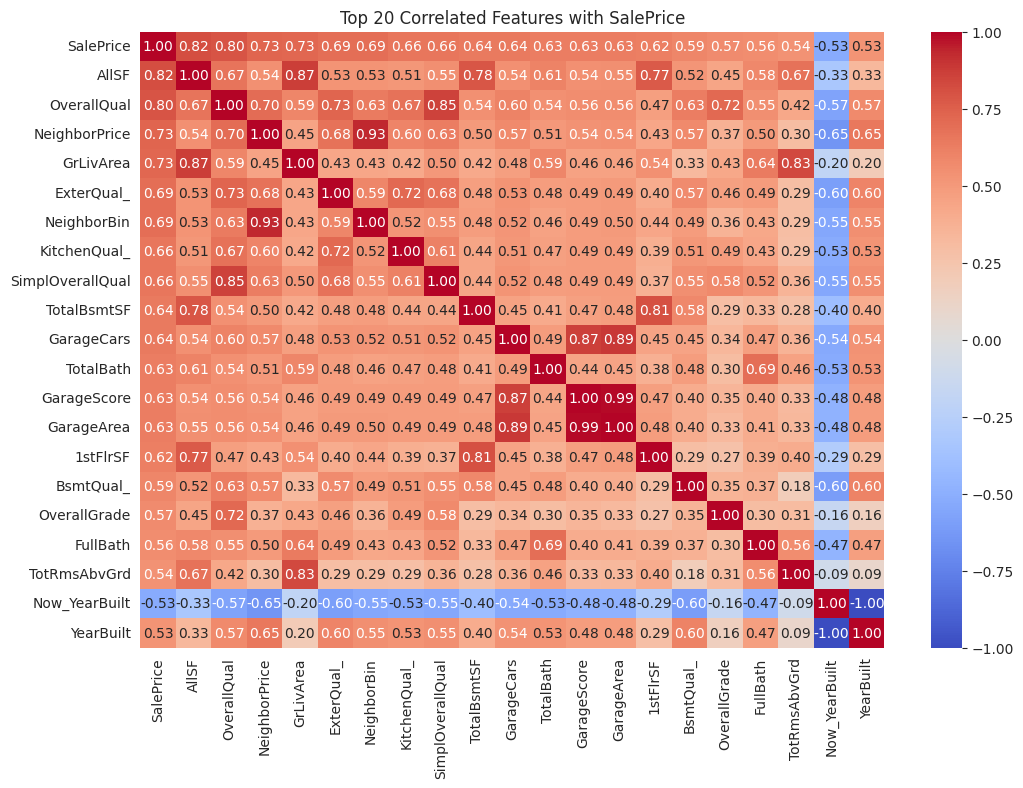

In [190]:
# Select only numeric columns from train_data_new and drop the 'Id' column.
# Explanation:
# - train_data_new.iloc[:train_length] selects the first train_length rows (the training set).
# - .select_dtypes(exclude=['object']) keeps only columns with numeric types (int, float).
# - .drop(['Id'], axis=1) removes the 'Id' column, which is just an identifier and not useful for correlation analysis.
data = train_data_new.iloc[:train_length].select_dtypes(exclude=['object']).drop(['Id'], axis=1)

# Create the correlation matrix for all numeric features.
# Explanation:
# - .corr() computes pairwise Pearson correlation coefficients between all numeric columns.
correlation_matrix = data.corr()

# Select the top 20 features most correlated with 'SalePrice'.
# Explanation:
# - correlation_matrix['SalePrice'].abs() gets the absolute correlation values with 'SalePrice'.
# - .nlargest(21) selects the top 21 (including 'SalePrice' itself).
# - .index gets the names of these features.
top_20_features = correlation_matrix['SalePrice'].abs().nlargest(21).index

# Plot the correlation matrix for the top 20 correlated features.
# Explanation:
# - plt.figure(figsize=(12, 8)) sets the plot size.
# - sns.heatmap() visualizes the correlation matrix for the selected features.
# - annot=True shows the correlation values in each cell.
# - cmap='coolwarm' sets the color map.
# - fmt=".2f" formats the numbers to 2 decimal places.
# - plt.title() adds a title to the plot.
# - plt.show() displays the plot.
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix.loc[top_20_features, top_20_features], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 20 Correlated Features with SalePrice")
plt.show()

In [192]:
# Select only the columns in top_20_features from the data DataFrame.
# Explanation:
# - data[top_20_features] filters the DataFrame to keep only the columns listed in top_20_features.
# - top_20_features contains the names of the 20 features most correlated with SalePrice, plus SalePrice itself.
# - This step is useful for focusing analysis or modeling on the most important features, reducing dimensionality and potential noise.
data = data[top_20_features]

# Print the names of the columns in the filtered data DataFrame.
# Explanation:
# - print(data.columns) displays the column names after filtering, allowing you to verify which features are included.
# - This is helpful for debugging and confirming that only the desired columns are present.
print(data.columns)

Index(['SalePrice', 'AllSF', 'OverallQual', 'NeighborPrice', 'GrLivArea',
       'ExterQual_', 'NeighborBin', 'KitchenQual_', 'SimplOverallQual',
       'TotalBsmtSF', 'GarageCars', 'TotalBath', 'GarageScore', 'GarageArea',
       '1stFlrSF', 'BsmtQual_', 'OverallGrade', 'FullBath', 'TotRmsAbvGrd',
       'Now_YearBuilt', 'YearBuilt'],
      dtype='object')


In [193]:
# Import necessary modules for modeling.
# from xgboost import XGBRegressor  # (commented out, not used here)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare target and features for training.
# - train_Y: The target variable (SalePrice) from the filtered data.
# - data.drop(['SalePrice'], axis=1, inplace=True): Remove SalePrice from features to avoid data leakage.
train_Y = data['SalePrice']
data.drop(['SalePrice'], axis=1, inplace=True)

# Split the data into training and validation sets.
# - train_test_split: Randomly splits the data into train and test sets (80% train, 20% test).
# - random_state=42 ensures reproducibility.
train_X, test_X, train_Y, test_Y = train_test_split(data, train_Y, test_size=0.2, random_state=42)

# Instantiate and fit a linear regression model.
# - regressor: LinearRegression model object.
# - regressor.fit(train_X, train_Y): Train the model using training features and target.
regressor = LinearRegression()
regressor.fit(train_X, train_Y)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [194]:
# Import mean_squared_error from scikit-learn to evaluate regression performance.
# Explanation:
# - mean_squared_error computes the average squared difference between predicted and actual values.
# - It is a common metric for regression tasks, indicating how close predictions are to true values.

from sklearn.metrics import mean_squared_error

# Use the trained regressor to predict SalePrice values for the test set.
# - test_X: Features for the validation/test split.
# - regressor.predict(test_X): Generates predicted SalePrice values.
test_Y_pred = regressor.predict(test_X)

# Calculate the mean squared error between actual and predicted SalePrice values.
# - mean_squared_error(test_Y, test_Y_pred): Compares true SalePrice (test_Y) to predictions.
# - Lower MSE indicates better model performance.
mse = mean_squared_error(test_Y, test_Y_pred)

# Print the mean squared error to assess model accuracy.
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 711102117.351543


In [195]:
import pickle
import os

# Save the trained regression model to disk using pickle.
# Explanation:
# - model_path specifies the directory where the model file will be saved ("models").
# - If the directory does not exist, os.makedirs(model_path) creates it.
# - The model is saved as 'linear_regression_model.pkl' inside the models directory.
# - pickle.dump(regressor, file) serializes the trained regressor object and writes it to the file.
# - This allows you to reload and use the trained model later without retraining.

model_path="models"
if not os.path.exists(model_path):
    os.makedirs(model_path)
with open(os.path.join(model_path, 'linear_regression_model.pkl'), 'wb') as file:
    pickle.dump(regressor, file)


In [196]:
# Get the needed features of the model to make prediction.
# Explanation:
# - regressor.feature_names_in_ contains the names of the features used to train the regression model.
# - The for loop iterates over each feature name.
# - train_X[feature].dtype retrieves the data type of each feature in the training set.
# - The print statement displays the feature name and its data type.
# - This is useful for verifying which features are required for prediction and ensuring the input data matches the expected types.
for feature in regressor.feature_names_in_:
    print(f"Feature: {feature}, type:{train_X[feature].dtype}")

Feature: AllSF, type:float64
Feature: OverallQual, type:int64
Feature: NeighborPrice, type:float64
Feature: GrLivArea, type:int64
Feature: ExterQual_, type:int64
Feature: NeighborBin, type:int64
Feature: KitchenQual_, type:int64
Feature: SimplOverallQual, type:int64
Feature: TotalBsmtSF, type:float64
Feature: GarageCars, type:float64
Feature: TotalBath, type:float64
Feature: GarageScore, type:float64
Feature: GarageArea, type:float64
Feature: 1stFlrSF, type:int64
Feature: BsmtQual_, type:int64
Feature: OverallGrade, type:int64
Feature: FullBath, type:int64
Feature: TotRmsAbvGrd, type:int64
Feature: Now_YearBuilt, type:int64
Feature: YearBuilt, type:int64
